### ESN application: El-Nino Southern Oscillation (ENSO)

Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). 

SST data: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc

Data contains **monthly mean SST** from 1854 .. 2021, in a 2° by 2° lat/lon grid:  
**lat:** 88N .. -88N (= 88S)  
**lon:** 0E .. 358E

Start from 1880, as in [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability".

**Outline**

- Calculate ENSO index
- Predict events (El Nino / La Nina / neutral) from ENSO index
- Optimize baseESN, try DeepESN and other ANN architectures for comparison

### Tech preamble

In [15]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
import tensorflow.keras.initializers as tfi
from tensorflow.keras.utils import plot_model

# Work with my own library of useful ESN functions
from ESN_functions_v03 import *

### Load SST data

In [16]:
# Use, when working with relative path on local machine (or nesh)
sst_path = "../data/sst.mnmean.nc"
sst_dataset = xr.open_dataset(sst_path)
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2015, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-12-06

### Calculating ENSO index from sst data

There are several indices used to monitor the tropical Pacific, all of which are based on SST anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The Niño 3.4 index is one of the most commonly used indices to define El Niño and La Niña events.

Website https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni gives introduction to ENSO indices. Paper [Morrow et al., 2010] shows index for Niño 3.4 region (5°N–5°S, 120–170°W) in the tropical Pacific. The website references a link to an "expert guide" with more detailed information and a recipe on calculating ENSO indices:

(...) Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. (...)

In [17]:
### Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take care
# care of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
sst_mean = sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01')).sel(lat=slice(5,-5)).sel(lon=slice(190,240)).mean(("lat", "lon"))

In [18]:
# Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño 3.4 region
sst_climatology = (
    sst_dataset.sst
    .sel(time=slice('1950-01-01','1979-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon", "time"))
)

In [19]:
# Compute std dev in ime for monthly climatology (e.g., 1950-1979), 
# use area averaged total SST from Niño 3.4 region
sst_climatology_std = (
    sst_dataset.sst
    .sel(time=slice('1950-01-01','1979-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .std("time")          
)

In [20]:
# Subtract climatology from area averaged total SST time series to obtain anomalies
sst_anomaly = sst_mean - sst_climatology

In [21]:
# Smooth the anomalies with a 5-month running mean to get ENSO index
ENSO_index = sst_anomaly.rolling(time=5, center=True).mean().dropna("time")

In [22]:
# Recipy for calculating ENSO index requires normalization of the smoothed anomalies
# by its standard deviation over the climatological period.
ENSO_index_norm = ENSO_index / sst_climatology_std

<function matplotlib.pyplot.show(close=None, block=None)>

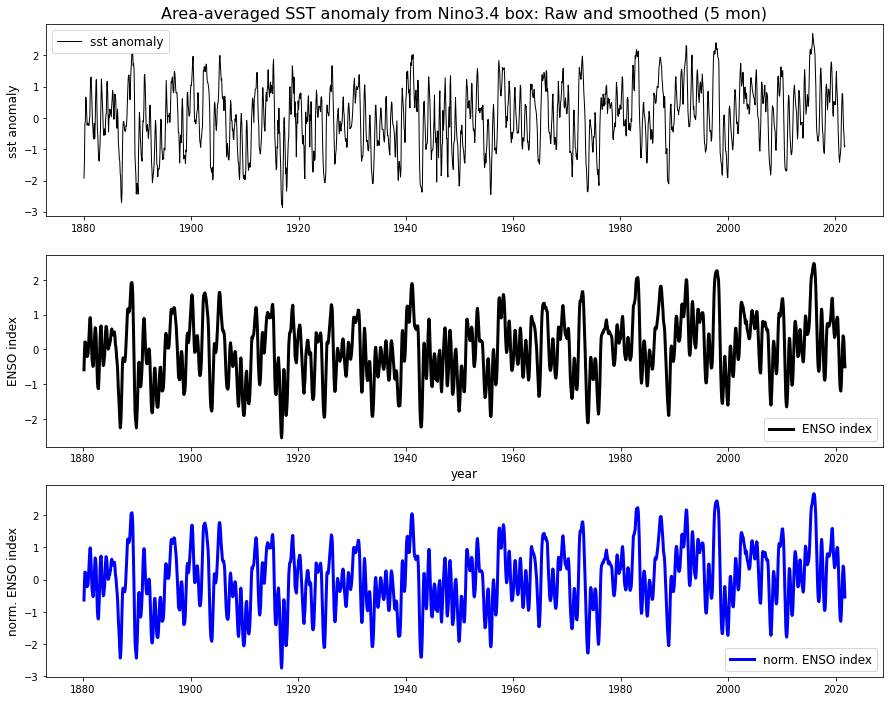

In [9]:
# First glance at raw sst anomaly timeseries and (un-)normalized ENSO index
fig, axes = plt.subplots(3, 1, figsize=(15,12))
axes[0].plot(sst_anomaly.time, sst_anomaly, label='sst anomaly', color='black', linewidth=1)
axes[1].plot(ENSO_index.time, ENSO_index, label='ENSO index', color='black', linewidth=3)
axes[2].plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='blue', linewidth=3)
axes[1].set_xlabel("year", fontsize=12)
axes[0].set_ylabel("sst anomaly", fontsize=12)
axes[1].set_ylabel("ENSO index", fontsize=12)
axes[2].set_ylabel("norm. ENSO index", fontsize=12)
axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)
axes[2].legend(fontsize=12)
axes[0].set_title("Area-averaged SST anomaly from Nino3.4 box: Raw and smoothed (5 mon)", fontsize=16)
plt.show

In [10]:
# Augmented Dickey-Fuller Test on normalized ENSO index: 
# Check, how strong timeseries is determined by possible trend.
ADFT_ENSO = adfuller(ENSO_index_norm)

# Print results from ADFT:
print('\nnorm. ENSO index:')
print('==================')
print('ADF Statistic: %f' % np.round(ADFT_ENSO[0],3))
print('p-value: %f' % np.round(ADFT_ENSO[1],3))


norm. ENSO index:
ADF Statistic: -6.553000
p-value: 0.000000


<function matplotlib.pyplot.show(close=None, block=None)>

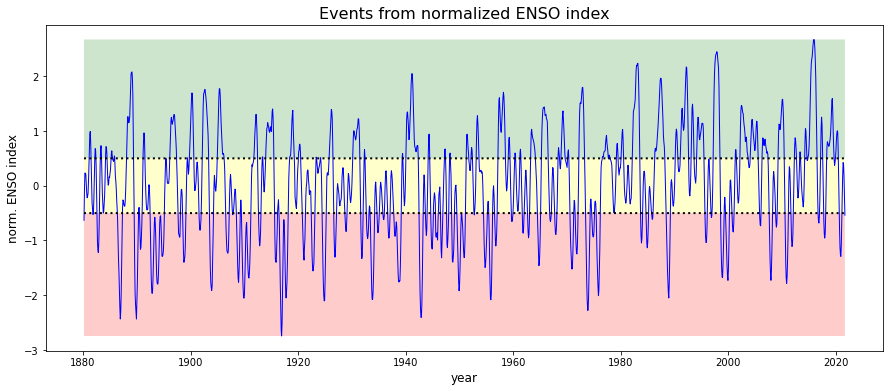

In [11]:
# Get min/max for norm. ENSO index, for plotting shaded areas separating events:
ENSO_min = np.min(ENSO_index_norm)
ENSO_max = np.max(ENSO_index_norm)

# Focus on normalized ENSO index: Highlight events.
# > 0.5: EL Nino, < -0.5: La Nina, else: 'neutral'
fig, axes = plt.subplots(1, 1, figsize=(15,6))
axes.plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='blue', linewidth=1)
axes.set_xlabel("year", fontsize=12)
axes.set_ylabel("norm. ENSO index", fontsize=12)
axes.set_title("Events from normalized ENSO index", fontsize=16)

# Add horizontal lines
axes.plot(ENSO_index_norm.time,0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)
axes.plot(ENSO_index_norm.time,-0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)

# Shade area highlighting distinct events.
axes.fill_between(np.array(ENSO_index_norm.time), 0.5, ENSO_max, facecolor='green', alpha=0.2)
axes.fill_between(np.array(ENSO_index_norm.time), -0.5, ENSO_min, facecolor='red', alpha=0.2)
axes.fill_between(np.array(ENSO_index_norm.time), -0.5, 0.5, facecolor='yellow', alpha=0.2)

plt.show

In [23]:
# Get number of events: Absolute and realtive to ALL events
print("\nnormalmized ENSO index")
print("======================")

print("\nTOTAL number of timesteps: ", len(ENSO_index_norm))
print("number of timesteps connected to EL Nino events: ", np.sum(ENSO_index_norm.values>0.5))
print("number of timesteps connected to La Nina events: ", np.sum(ENSO_index_norm.values<-0.5))
print("number of timesteps connected to neutral events: ", np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)))

print("\nrel. amount of EL Nino events: ", np.round(np.sum(ENSO_index_norm.values>0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of La Nina events: ", np.round(np.sum(ENSO_index_norm.values<-0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of neutral events: ", np.round(np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)) / len(ENSO_index_norm)*100,1), "%")


normalmized ENSO index

TOTAL number of timesteps:  1699
number of timesteps connected to EL Nino events:  549
number of timesteps connected to La Nina events:  501
number of timesteps connected to neutral events:  649

rel. amount of EL Nino events:  32.3 %
rel. amount of La Nina events:  29.5 %
rel. amount of neutral events:  38.2 %


<function matplotlib.pyplot.show(close=None, block=None)>

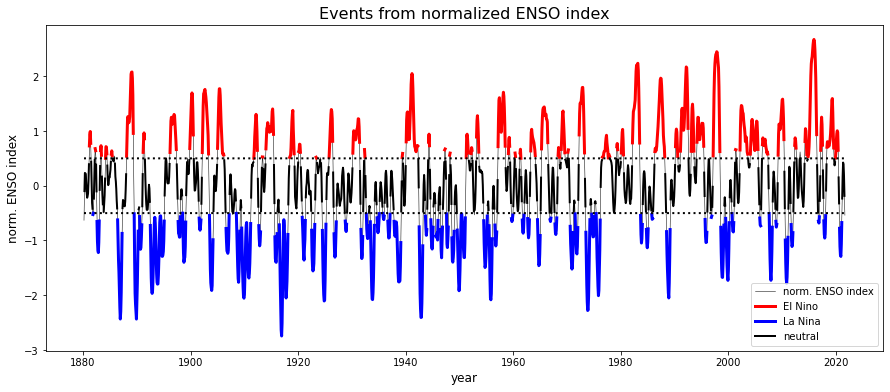

In [13]:
## Another way of highlighting distinct events:

# Mask events for plotting them in different colors
ENSO_ElNino = np.ma.masked_where(ENSO_index_norm.values < 0.5, ENSO_index_norm.values)
ENSO_LaNina = np.ma.masked_where(ENSO_index_norm.values > -0.5, ENSO_index_norm.values)
ENSO_neutral = np.ma.masked_where((ENSO_index_norm.values >= 0.5) | (ENSO_index_norm.values <= -0.5), ENSO_index_norm.values)

# Focus on normalized ENSO index: Highlight events.
# > 0.5: EL Nino, < -0.5: La Nina, else: 'neutral'
fig, axes = plt.subplots(1, 1, figsize=(15,6))
axes.plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='black', linewidth=0.5)
axes.plot(ENSO_index_norm.time, ENSO_ElNino, label='El Nino', color='red', linewidth=3)
axes.plot(ENSO_index_norm.time, ENSO_LaNina, label='La Nina', color='blue', linewidth=3)
axes.plot(ENSO_index_norm.time, ENSO_neutral, label='neutral', color='black', linewidth=2)

axes.set_xlabel("year", fontsize=12)
axes.set_ylabel("norm. ENSO index", fontsize=12)
axes.set_title("Events from normalized ENSO index", fontsize=16)
axes.legend()

# Add horizontal lines
axes.plot(ENSO_index_norm.time,0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)
axes.plot(ENSO_index_norm.time,-0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)

plt.show

### Discussion on ENSO index

Having the normalized ENSO index, one usually refers to "El Nino" and "La Nina" events for index higher 0.5 or lower -0.5, respectively, hence +/- 0.5 standard deviations of climatology, since that's how we normalized the index.

One could also think about being more selective and define events only in case the indes deviates by +/- 1.0 standard deviations, to get clearer signals and less noise in events.

In [31]:
### Set some of the parameters up-front for splitting timeseries:

## Verbosity:
verbose = True

## Parameters for decomposing and splitting timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 6 # Define target length.
scaled_YN = False # If True: Scale input series with min/max scaling, where min/max are taken only from train data!
scale_to = 'zero_one' # If scaling is desired, choose interval to scale to: 'zero_one' --> [0,1] or 'one_one' --> [-1,1]

In [32]:
# Split normalized ENSO index to train/val input/target:
train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                    input_length=input_length,
                                                                                    target_length=target_length,
                                                                                    time_lag=0, 
                                                                                    train_val_split=0.8,
                                                                                    val_samples_from='end',
                                                                                    abs_to_rel_YN=False,
                                                                                    binary_YN=False,
                                                                                    scaled_YN=scaled_YN,
                                                                                    scale_to=scale_to,
                                                                                    verbose=verbose)

raw data shape:  (1699,)
train_input shape:  (1347, 10, 1)
val_input shape:  (337, 10, 1)
train_target shape:  (1347, 1)
val_target shape:  (337, 1)
train_min:  0
train_max:  0


In [33]:
### Try to model normalized ENSO index with base ESN. Define parameters for ESN model upfront

n_layers = 1 # Number of ESN layers in the model.
n_res = 100 # Number of reservoir units.
W_in_lim = 1.0 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
activation = 'sigmoid' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.9 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

In [34]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, activation=activation, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 10, 1)]           0         
_________________________________________________________________
esn_101 (ESN)                ((None, 10, 100), (None,  10300     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 10, 1)]           0         
_________________________________________________________________
esn_101 (ESN)                ((None, 10, 100), (None,  10300     
Total params: 10,300
Trainable param

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:693: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:732: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (1347, 10, 1)
shape of model output X_T (samples, n_res):  (1347, 100)

W_out shape:  (100, 1)
b_out shape:  (1,)

Final reservoir states in augmented notation, shape:  (1347, 101)

train_target shape (samples, output features):  (1347, 1)
W_out_prime shape:  (101, 1)

trained b_out: 
 [671532.75307516]


/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:769: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


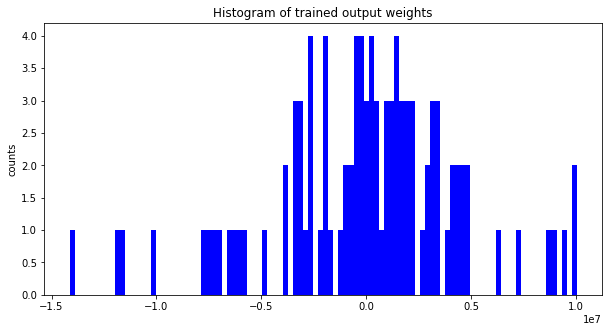

In [35]:
# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


shape of val input (samples, timesteps, features):  (337, 10, 1)
shape of train input (samples, timesteps, features):  (1347, 10, 1)

shape of model predictions on validation input (samples, 1):  (337, 1)
shape of val targets (samples, 1):  (337, 1)

train_mae:  0.5407
val_mae:  1.2362

train_mse:  0.4481
val_mse:  8.225


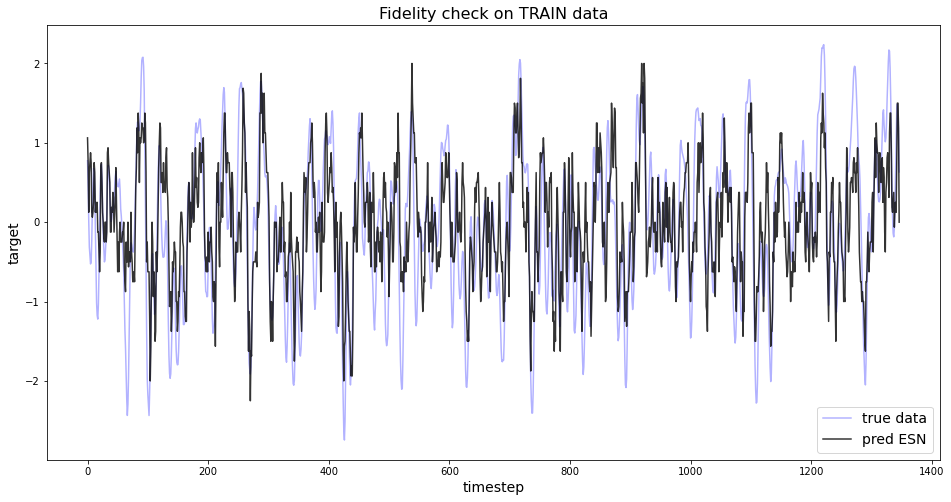

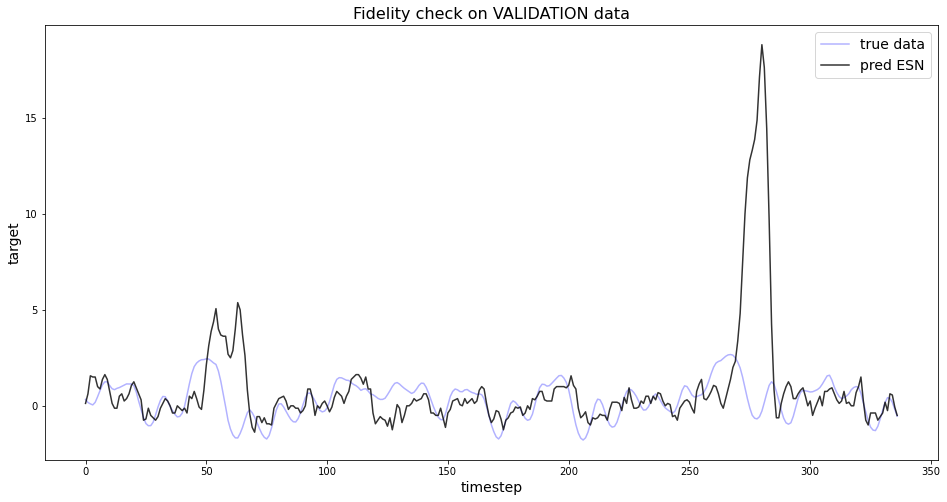

In [36]:
# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target, val_target,
                                                                       verbose=verbose)

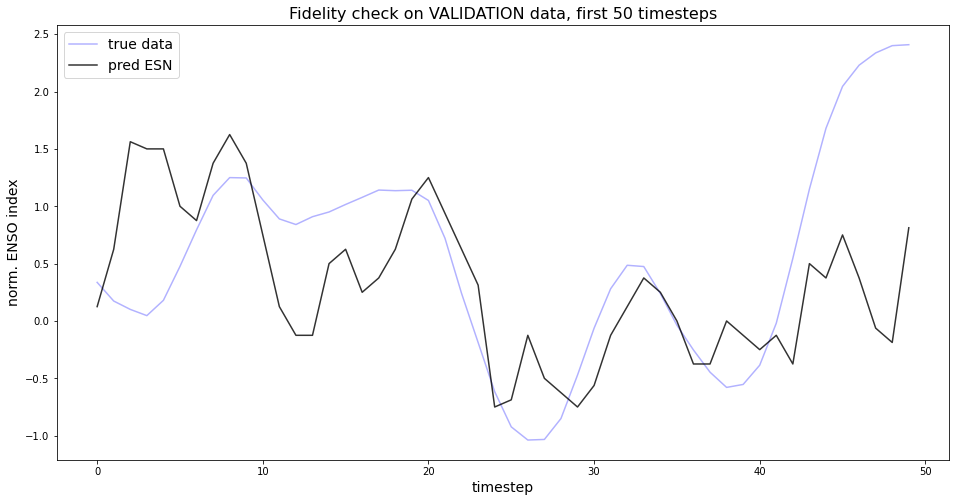

In [37]:
# Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:50])),val_target[:50],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:50])),val_pred[:50],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [38]:
# Check accuracy: How often is the correct label predicted?
# Get number of events: Absolute and realtive to ALL events

print("\nnormalmized ENSO index")
print("======================")

print("\nTOTAL number of timesteps: ", len(ENSO_index_norm))
print("number of EL Nino events: ", np.sum(ENSO_index_norm.values>0.5))
print("number of La Nina events: ", np.sum(ENSO_index_norm.values<-0.5))
print("number of neutral events: ", np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)))

print("\nrel. amount of EL Nino events: ", np.round(np.sum(ENSO_index_norm.values>0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of La Nina events: ", np.round(np.sum(ENSO_index_norm.values<-0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of neutral events: ", np.round(np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)) / len(ENSO_index_norm)*100,1), "%")




normalmized ENSO index

TOTAL number of timesteps:  1699
number of EL Nino events:  549
number of La Nina events:  501
number of neutral events:  649

rel. amount of EL Nino events:  32.3 %
rel. amount of La Nina events:  29.5 %
rel. amount of neutral events:  38.2 %


In [39]:
# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
val_acc_neutral = sum((((val_pred>=-0.5) & (val_pred<=0.5)) == ((val_target>=-0.5) & (val_target<=0.5))) &
                       ((val_target>=-0.5) & (val_target<=0.5))) / sum(((val_target>=-0.5) & (val_target<=0.5)))

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))
train_acc_neutral = sum((((train_pred>=-0.5) & (train_pred<=0.5)) == ((train_target>=-0.5) & (train_target<=0.5))) &
                       ((train_target>=-0.5) & (train_target<=0.5))) / sum(((train_target>=-0.5) & (train_target<=0.5)))

In [40]:
# Get accuracy for target_length=1
# Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
#       to have that same event.
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.49
La Nina:  0.34
neutral:  0.64

Train accuracy:
El Nino:  0.5
La Nina:  0.51
neutral:  0.7


In [165]:
# target_length=3
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.65
La Nina:  0.59
neutral:  0.79

Train accuracy:
El Nino:  0.74
La Nina:  0.79
neutral:  0.79


In [185]:
# target_length=6
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.44
La Nina:  0.47
neutral:  0.66

Train accuracy:
El Nino:  0.5
La Nina:  0.56
neutral:  0.67


In [127]:
## Try multistep prediction with a sequence of one-step predictions with target_length=1 in free-float modus:
## Feed prediction as new input for next step's prediction, hence no "teacher-forcing".
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)

# Set number of free-float timesteps:
n_steps = 6

# Copy original val_input, not to "destroy" it
val_input_temp = np.copy(val_input)

# Loop over desired number of free-float timesteps:
for step in range(n_steps):
    
    # Get prediction for current timestep
    val_pred = model.predict(val_input_temp)
    
    # If first timestep, initialize storage for prediction of ALL timesteps (val_samples, n_steps)
    if step == 0:
        val_pred_all = np.copy(val_pred)
    
    else:
        val_pred_all = np.concatenate([val_pred_all, val_pred], axis=-1)

    ## Create inputs for second timestep from two ingredients:
    # Take all but the first input timesteps from previous input samples:
    temp1 = np.copy(val_input[:,1:,0:1])

    # Reshape predictions from previous timestep:
    temp2 = np.reshape(val_pred,(val_pred.shape[0], 1, 1))

    # Concatenate both ingredients to create input for next timestep:
    val_input_temp = np.concatenate([temp1, temp2], axis=1)

print("shape of val_pred_all (samples, n_steps): ", val_pred_all.shape)


shape of val input (samples, timesteps, features):  (338, 10, 1)
shape of val_pred_all (samples, n_steps):  (338, 6)


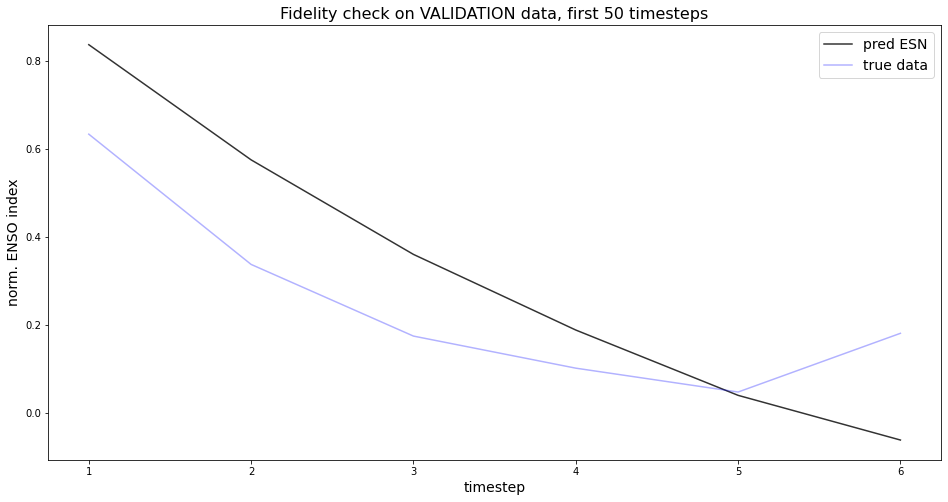

In [128]:
# Fidelity check: Plot free-float predictions vs. true validation targets

# sample
i = 0

plt.figure(figsize=(16,8))
plt.plot(range(1,n_steps+1),val_pred_all[i],'k',label="pred ESN", alpha=0.8)
plt.plot(range(1,n_steps+1),val_target[i:i+n_steps,0],'b',label="true data", alpha=0.3)
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

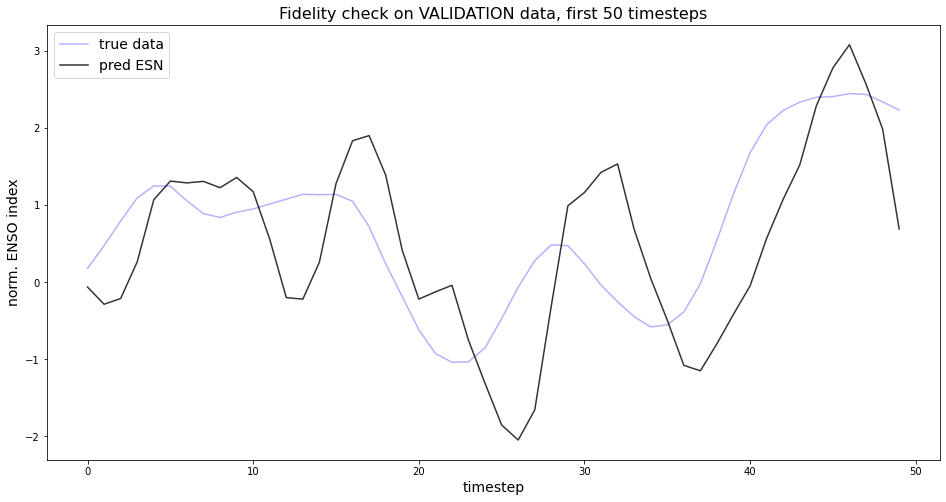

In [124]:
# look at timestep j
j = 5

# Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[j:50+j])),val_target[j:50+j],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_all[:50,j])),val_pred_all[:50,j],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Optimizing (Hyper-)parameters using Gradient Descent

So far we have implemented functionality to set up ESN models, train output weights and bias, get model predictions and evaluate model performance.

We are able to apply ESN methodology to a well-known climate problem: El Nino Southern Oscillation (ENSO).

Now we aim to optimize (hyper-)parameters for a base ESN model with just *one* reservoir. A classic approach would be gridsearch optimization. To be able to visualize gridsearch results in heatmaps, one is limited to simultaneously optimize only *two* parameters. In addition to that, the *whole* parameter space is often too large to try *all* possible parameter combinations.

Inspired by stochastic gradient descent - used in training artificial neural networks - we will try to use some kind of gradient descent algorithm to simultaneously optimize *all* desired (hyper-)parameters.

We work with normalized ENSO index, unscaled and with fixed target_length = 1, number of input features reads n_features = 1. As mentioned, we start with optimizing parameters for a base ESN, hence n_layers = 1. Here is an overview of (hyper-)parameters, we aim to optimize in a first attempt:

- input_length: Number of timesteps per input sample.
- n_res: Number of reservoir units.
- W_in_lim: Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
- leak_rate: Leak rate used in transition function of reservoir states.
- spec_radius: Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
- sparsity: Sparsity of reservoir weight matrix.

As activation function to be used in calculating reservoir state transition we start with 'sigmoid', and repeat optimization for 'tanh'.

#### Outline of gradient descent algorithm

1. Set range for each parameter (parameter_min / _max): Optimization is only performed within chosen range.
2. Set initial parameter values within specified range (parameter_base).
3. Set step size for each parameter used over the whole optimization process (parameter_step).
4. Set n_iterations, as maximal number of optimization iterations.
5. Set n_runs, defining how many runs we average over in each iteration, to achieve stable metrics and gradients.
6. Start iterating:

a. Start runs: base parameter setting

- split_data according to chosen input_length to get train and validation inputs and targets.
- setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
- trainESN to train output weights and bias.
- predESN to get metrics [mae, mse] on train and validation data.
- Get base_train_mae and _mse as average over n_runs.
- Store base_train_mae / _mse and base_val_mae / _mse and current parameter setting.

b. Start runs: modify each parameter individually (up and down)

- split_data, setESN, trainESN, predESN
- Get param_up_train_mae / _mse and param_down_train_mae / _mse as average over n_runs on train data.

c. Estimate gradients for each parameter, when modifying parameter up / down, focus on **train mse**

- Calculate differences: param_up_grad = param_up_train_mse - base_train_mse, param_down_grad = param_down_train_mse - base_train_mse

d. Modify parameter setting according to gradients

- Modify each parameter according to specified step size in the direction of lowest gradient.
- Leave parameter unchanged, if both gradients (_up and _down) are positive, hence modification would lower model performance.
- Also leave parameter unchanged, if modification would lead parameter out of specified range.

e. Early stop iteration process

- Break out of iteration, when all parameters are left unchanged.

7. Plot results:

- Plot mae and mse over iterations for train and validation data.
- Plot parameters over iterations.


In [9]:
### Set parameters for optimization:

## Verbosity: Mute interim outputs from split_data, setESN, trainESN and predESN
verbose = False

## Parameters for splitting timeseries and setting up ESN model, that are kept UNCHANGED in optimization:
target_length = 1 # Define target length.
scaled_YN = False # If True: Scale input series with min/max scaling, where min/max are taken only from train data!
scale_to = 'zero_one' # If scaling is desired, choose interval to scale to: 'zero_one' --> [0,1] or 'one_one' --> [-1,1]
n_layers = 1 # Number of ESN layers in the model.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4
activation = 'sigmoid' # Desired activation function to be used in calculating reservoir state transition.

## Parameters to optimized: Initial values, range for optimization (_min / _max) and step size (_step)

# Split input series into samples of specified input length.
input_length_base = 10 
input_length_min = 5
input_length_max = 20
input_length_step = 1

# Number of reservoir units.
n_res_base = 100 
n_res_min = 60
n_res_max = 300
n_res_step = 20

# Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
W_in_lim_base = 0.5 
W_in_lim_min = 0.1
W_in_lim_max = 1
W_in_lim_step = 0.1

# Leak rate used in transition function of reservoir states.
leak_rate_base = 0.1 
leak_rate_min = 0.01
leak_rate_max = 0.2
leak_rate_step = 0.01

# Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
spec_radius_base = 0.8 
spec_radius_min = 0.1
spec_radius_max = 1.1
spec_radius_step = 0.1

# Sparsity of reservoir weight matrix.
sparsity_base = 0.2 
sparsity_min = 0.1
sparsity_max = 0.4
sparsity_step = 0.02

## Parameters for optimization process:

# (max.) number of iterations
n_iterations = 20

# Number of runs we average over in each iteration, to achieve stable metrics and gradients.
n_runs = 10

In [10]:
### Optimization of (hyper-)parameters for base ESN

## Initialize storage for mae and mse over iterations for train and validation data:
train_mae_all = []
train_mse_all = []
val_mae_all = []
val_mse_all = []

## Initialize storage for parameters over iterations: Store initial parameter setting.
input_length_all = [input_length_base]
n_res_all = [n_res_base]
W_in_lim_all = [W_in_lim_base]
leak_rate_all = [leak_rate_base]
spec_radius_all = [spec_radius_base]
sparsity_all = [sparsity_base]

## Loop over (max.) number of iterations:
for iteration in range(n_iterations):
    
    # Print status:
    print("\niteration :", iteration+1, "from ", n_iterations)
    
    ## Loop over desired number of runs per iteration, to get metrics on current base setting:
    
    # Initialize storage for base_mae / _mse on train / validation data:
    base_train_mae = 0
    base_train_mse = 0
    base_val_mae = 0
    base_val_mse = 0
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length_base,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)

    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        base_train_mae += train_mae
        base_train_mse += train_mse
        base_val_mae += val_mae
        base_val_mse += val_mse
        
    # Store averaged base mae / mse on train / validation data:
    base_train_mae = base_train_mae / n_runs
    base_train_mse = base_train_mse / n_runs
    base_val_mae = base_val_mae / n_runs
    base_val_mse = base_val_mse / n_runs

    train_mae_all.append(base_train_mae)
    train_mse_all.append(base_train_mse)
    val_mae_all.append(base_val_mae)
    val_mse_all.append(base_val_mse)
    
    
    ## Change only input_length UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if input_length_base + input_length_step <= input_length_max:
        input_length = input_length_base + input_length_step
    else:
        input_length = input_length_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    input_length_UP_train_mae = 0
    input_length_UP_train_mse = 0
    input_length_UP_val_mae = 0
    input_length_UP_val_mse = 0
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)
        
    for run in range(n_runs):

        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)        

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        input_length_UP_train_mae += train_mae
        input_length_UP_train_mse += train_mse
        input_length_UP_val_mae += val_mae
        input_length_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    input_length_UP_train_mae = input_length_UP_train_mae / n_runs
    input_length_UP_train_mse = input_length_UP_train_mse / n_runs
    input_length_UP_val_mae = input_length_UP_val_mae / n_runs
    input_length_UP_val_mse = input_length_UP_val_mse / n_runs
    

    ## Change only input_length DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if input_length_base - input_length_step >= input_length_min:
        input_length = input_length_base - input_length_step
    else:
        input_length = input_length_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    input_length_DOWN_train_mae = 0
    input_length_DOWN_train_mse = 0
    input_length_DOWN_val_mae = 0
    input_length_DOWN_val_mse = 0
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)

    for run in range(n_runs):

        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        input_length_DOWN_train_mae += train_mae
        input_length_DOWN_train_mse += train_mse
        input_length_DOWN_val_mae += val_mae
        input_length_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    input_length_DOWN_train_mae = input_length_DOWN_train_mae / n_runs
    input_length_DOWN_train_mse = input_length_DOWN_train_mse / n_runs
    input_length_DOWN_val_mae = input_length_DOWN_val_mae / n_runs
    input_length_DOWN_val_mse = input_length_DOWN_val_mse / n_runs
       
       
    ## Next change further parameters UP/DOWN, but keep input data fixed, so split data upfront.
    ## Use current iteration's base input_length!
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length_base,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)

    
    ## Change only n_res UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if n_res_base + n_res_step <= n_res_max:
        n_res = n_res_base + n_res_step
    else:
        n_res = n_res_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    n_res_UP_train_mae = 0
    n_res_UP_train_mse = 0
    n_res_UP_val_mae = 0
    n_res_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        n_res_UP_train_mae += train_mae
        n_res_UP_train_mse += train_mse
        n_res_UP_val_mae += val_mae
        n_res_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    n_res_UP_train_mae = n_res_UP_train_mae / n_runs
    n_res_UP_train_mse = n_res_UP_train_mse / n_runs
    n_res_UP_val_mae = n_res_UP_val_mae / n_runs
    n_res_UP_val_mse = n_res_UP_val_mse / n_runs
    

    ## Change only n_res DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if n_res_base - n_res_step >= n_res_min:
        n_res = n_res_base - n_res_step
    else:
        n_res = n_res_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    n_res_DOWN_train_mae = 0
    n_res_DOWN_train_mse = 0
    n_res_DOWN_val_mae = 0
    n_res_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        n_res_DOWN_train_mae += train_mae
        n_res_DOWN_train_mse += train_mse
        n_res_DOWN_val_mae += val_mae
        n_res_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    n_res_DOWN_train_mae = n_res_DOWN_train_mae / n_runs
    n_res_DOWN_train_mse = n_res_DOWN_train_mse / n_runs
    n_res_DOWN_val_mae = n_res_DOWN_val_mae / n_runs
    n_res_DOWN_val_mse = n_res_DOWN_val_mse / n_runs
    
    
    ## Change only W_in_lim UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if W_in_lim_base + W_in_lim_step <= W_in_lim_max:
        W_in_lim = W_in_lim_base + W_in_lim_step
    else:
        W_in_lim = W_in_lim_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    W_in_lim_UP_train_mae = 0
    W_in_lim_UP_train_mse = 0
    W_in_lim_UP_val_mae = 0
    W_in_lim_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        W_in_lim_UP_train_mae += train_mae
        W_in_lim_UP_train_mse += train_mse
        W_in_lim_UP_val_mae += val_mae
        W_in_lim_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    W_in_lim_UP_train_mae = W_in_lim_UP_train_mae / n_runs
    W_in_lim_UP_train_mse = W_in_lim_UP_train_mse / n_runs
    W_in_lim_UP_val_mae = W_in_lim_UP_val_mae / n_runs
    W_in_lim_UP_val_mse = W_in_lim_UP_val_mse / n_runs
    

    ## Change only W_in_lim DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if W_in_lim_base - W_in_lim_step >= W_in_lim_min:
        W_in_lim = W_in_lim_base - W_in_lim_step
    else:
        W_in_lim_ = W_in_lim_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    W_in_lim_DOWN_train_mae = 0
    W_in_lim_DOWN_train_mse = 0
    W_in_lim_DOWN_val_mae = 0
    W_in_lim_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        W_in_lim_DOWN_train_mae += train_mae
        W_in_lim_DOWN_train_mse += train_mse
        W_in_lim_DOWN_val_mae += val_mae
        W_in_lim_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    W_in_lim_DOWN_train_mae = W_in_lim_DOWN_train_mae / n_runs
    W_in_lim_DOWN_train_mse = W_in_lim_DOWN_train_mse / n_runs
    W_in_lim_DOWN_val_mae = W_in_lim_DOWN_val_mae / n_runs
    W_in_lim_DOWN_val_mse = W_in_lim_DOWN_val_mse / n_runs
    
    
    ## Change only leak_rate UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if leak_rate_base + leak_rate_step <= leak_rate_max:
        leak_rate = leak_rate_base + leak_rate_step
    else:
        leak_rate = leak_rate_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    leak_rate_UP_train_mae = 0
    leak_rate_UP_train_mse = 0
    leak_rate_UP_val_mae = 0
    leak_rate_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        leak_rate_UP_train_mae += train_mae
        leak_rate_UP_train_mse += train_mse
        leak_rate_UP_val_mae += val_mae
        leak_rate_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    leak_rate_UP_train_mae = leak_rate_UP_train_mae / n_runs
    leak_rate_UP_train_mse = leak_rate_UP_train_mse / n_runs
    leak_rate_UP_val_mae = leak_rate_UP_val_mae / n_runs
    leak_rate_UP_val_mse = leak_rate_UP_val_mse / n_runs
    

    ## Change only leak_rate DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if leak_rate_base - leak_rate_step >= leak_rate_min:
        leak_rate = leak_rate_base - leak_rate_step
    else:
        leak_rate = leak_rate_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    leak_rate_DOWN_train_mae = 0
    leak_rate_DOWN_train_mse = 0
    leak_rate_DOWN_val_mae = 0
    leak_rate_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        leak_rate_DOWN_train_mae += train_mae
        leak_rate_DOWN_train_mse += train_mse
        leak_rate_DOWN_val_mae += val_mae
        leak_rate_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    leak_rate_DOWN_train_mae = leak_rate_DOWN_train_mae / n_runs
    leak_rate_DOWN_train_mse = leak_rate_DOWN_train_mse / n_runs
    leak_rate_DOWN_val_mae = leak_rate_DOWN_val_mae / n_runs
    leak_rate_DOWN_val_mse = leak_rate_DOWN_val_mse / n_runs
    
    
    ## Change only spec_radius UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if spec_radius_base + spec_radius_step <= spec_radius_max:
        spec_radius = spec_radius_base + spec_radius_step
    else:
        spec_radius = spec_radius_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    spec_radius_UP_train_mae = 0
    spec_radius_UP_train_mse = 0
    spec_radius_UP_val_mae = 0
    spec_radius_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        spec_radius_UP_train_mae += train_mae
        spec_radius_UP_train_mse += train_mse
        spec_radius_UP_val_mae += val_mae
        spec_radius_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    spec_radius_UP_train_mae = spec_radius_UP_train_mae / n_runs
    spec_radius_UP_train_mse = spec_radius_UP_train_mse / n_runs
    spec_radius_UP_val_mae = spec_radius_UP_val_mae / n_runs
    spec_radius_UP_val_mse = spec_radius_UP_val_mse / n_runs
    

    ## Change only spec_radius DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if spec_radius_base - spec_radius_step >= spec_radius_min:
        spec_radius = spec_radius_base - spec_radius_step
    else:
        spec_radius = spec_radius_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    spec_radius_DOWN_train_mae = 0
    spec_radius_DOWN_train_mse = 0
    spec_radius_DOWN_val_mae = 0
    spec_radius_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        spec_radius_DOWN_train_mae += train_mae
        spec_radius_DOWN_train_mse += train_mse
        spec_radius_DOWN_val_mae += val_mae
        spec_radius_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    spec_radius_DOWN_train_mae = spec_radius_DOWN_train_mae / n_runs
    spec_radius_DOWN_train_mse = spec_radius_DOWN_train_mse / n_runs
    spec_radius_DOWN_val_mae = spec_radius_DOWN_val_mae / n_runs
    spec_radius_DOWN_val_mse = spec_radius_DOWN_val_mse / n_runs


    ## Change only sparsity UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if sparsity_base + sparsity_step <= sparsity_max:
        sparsity = sparsity_base + sparsity_step
    else:
        sparsity = sparsity_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    sparsity_UP_train_mae = 0
    sparsity_UP_train_mse = 0
    sparsity_UP_val_mae = 0
    sparsity_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        sparsity_UP_train_mae += train_mae
        sparsity_UP_train_mse += train_mse
        sparsity_UP_val_mae += val_mae
        sparsity_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    sparsity_UP_train_mae = sparsity_UP_train_mae / n_runs
    sparsity_UP_train_mse = sparsity_UP_train_mse / n_runs
    sparsity_UP_val_mae = sparsity_UP_val_mae / n_runs
    sparsity_UP_val_mse = sparsity_UP_val_mse / n_runs
    

    ## Change only sparsity DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if sparsity_base - sparsity_step >= sparsity_min:
        sparsity = sparsity_base - sparsity_step
    else:
        sparsity = sparsity_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    sparsity_DOWN_train_mae = 0
    sparsity_DOWN_train_mse = 0
    sparsity_DOWN_val_mae = 0
    sparsity_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        sparsity_DOWN_train_mae += train_mae
        sparsity_DOWN_train_mse += train_mse
        sparsity_DOWN_val_mae += val_mae
        sparsity_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    sparsity_DOWN_train_mae = sparsity_DOWN_train_mae / n_runs
    sparsity_DOWN_train_mse = sparsity_DOWN_train_mse / n_runs
    sparsity_DOWN_val_mae = sparsity_DOWN_val_mae / n_runs
    sparsity_DOWN_val_mse = sparsity_DOWN_val_mse / n_runs
    
    
    
    ## Estimate gradients for each parameter, when modifying parameter up / down, focus on train mse
    
    # Calculate differences: param_up_grad = param_up_train_mse - base_train_mse, 
    #                        param_down_grad = param_down_train_mse - base_train_mse

    # input_length
    input_length_UP_grad = input_length_UP_train_mse - base_train_mse
    input_length_DOWN_grad = input_length_DOWN_train_mse - base_train_mse
    
    # n_res
    n_res_UP_grad = n_res_UP_train_mse - base_train_mse
    n_res_DOWN_grad = n_res_DOWN_train_mse - base_train_mse
    
    # W_in_lim
    W_in_lim_UP_grad = W_in_lim_UP_train_mse - base_train_mse
    W_in_lim_DOWN_grad = W_in_lim_DOWN_train_mse - base_train_mse
    
    # leak_rate
    leak_rate_UP_grad = leak_rate_UP_train_mse - base_train_mse
    leak_rate_DOWN_grad = leak_rate_DOWN_train_mse - base_train_mse
    
    # spec_radius
    spec_radius_UP_grad = spec_radius_UP_train_mse - base_train_mse
    spec_radius_DOWN_grad = spec_radius_DOWN_train_mse - base_train_mse
    
    # sparsity
    sparsity_UP_grad = sparsity_UP_train_mse - base_train_mse
    sparsity_DOWN_grad = sparsity_DOWN_train_mse - base_train_mse

    
    ## Modify parameter setting according to gradients:
    
    # Modify each parameter according to specified step size in the direction of lowest gradient.
    # Leave parameter unchanged, if both gradients (_up and _down) are positive, 
    # hence modification would lower model performance.
    # Also leave parameter unchanged, if modification would lead parameter out of specified range.

    # input_length
    if (input_length_UP_grad < input_length_DOWN_grad) & (input_length_UP_grad < 0):
        input_length_base = input_length_base + input_length_step
    elif (input_length_UP_grad >= input_length_DOWN_grad) & (input_length_DOWN_grad < 0):
        input_length_base = input_length_base - input_length_step
        
    # n_res
    if (n_res_UP_grad < n_res_DOWN_grad) & (n_res_UP_grad < 0):
        n_res_base = n_res_base + n_res_step
    elif (n_res_UP_grad >= n_res_DOWN_grad) & (n_res_DOWN_grad < 0):
        n_res_base = n_res_base - n_res_step

    # W_in_lim
    if (W_in_lim_UP_grad < W_in_lim_DOWN_grad) & (W_in_lim_UP_grad < 0):
        W_in_lim_base = W_in_lim_base + W_in_lim_step
    elif (W_in_lim_UP_grad >= W_in_lim_DOWN_grad) & (W_in_lim_DOWN_grad < 0):
        W_in_lim_base = W_in_lim_base - W_in_lim_step
        
     # leak_rate
    if (leak_rate_UP_grad < leak_rate_DOWN_grad) & (leak_rate_UP_grad < 0):
        leak_rate_base = leak_rate_base + leak_rate_step
    elif (leak_rate_UP_grad >= leak_rate_DOWN_grad) & (leak_rate_DOWN_grad < 0):
        leak_rate_base = leak_rate_base - leak_rate_step
        
    # spec_radius
    if (spec_radius_UP_grad < spec_radius_DOWN_grad) & (spec_radius_UP_grad < 0):
        spec_radius_base = spec_radius_base + spec_radius_step
    elif (spec_radius_UP_grad >= spec_radius_DOWN_grad) & (spec_radius_DOWN_grad < 0):
        spec_radius_base = spec_radius_base - spec_radius_step

    # sparsity
    if (sparsity_UP_grad < sparsity_DOWN_grad) & (sparsity_UP_grad < 0):
        sparsity_base = sparsity_base + sparsity_step
    elif (sparsity_UP_grad >= sparsity_DOWN_grad) & (sparsity_DOWN_grad < 0):
        sparsity_base = sparsity_base - sparsity_step
        
    ## Store modified parameter setting.
    input_length_all.append(input_length_base)
    n_res_all.append(n_res_base)
    W_in_lim_all.append(W_in_lim_base)
    leak_rate_all.append(leak_rate_base)
    spec_radius_all.append(spec_radius_base)
    sparsity_all.append(sparsity_base)
    
    ##########(... only implemented UP/DOWN adjustment for input_length, add other parameters!!! ...)

## After iterations are done, need final model performance taking final parameter modifications into account.
## Loop over desired number of runs per iteration, to get metrics on current base setting:
    
# Initialize storage for base_mae / _mse on train / validation data:
base_train_mae = 0
base_train_mse = 0
base_val_mae = 0
base_val_mse = 0
    
for run in range(n_runs):

    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length_base,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)




    # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
    model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                n_res=n_res_base,W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                verbose=verbose)

    # trainESN to train output weights and bias.
    model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


    # predESN to get metrics [mae, mse] on train and validation data.
    train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                           train_target, val_target,
                                                                           verbose=verbose)

    # Store current run's mae / mse on train / validation data:
    base_train_mae += train_mae
    base_train_mse += train_mse
    base_val_mae += val_mae
    base_val_mse += val_mse

# Store averaged base mae / mse on train / validation data:
base_train_mae = base_train_mae / n_runs
base_train_mse = base_train_mse / n_runs
base_val_mae = base_val_mae / n_runs
base_val_mse = base_val_mse / n_runs

train_mae_all.append(base_train_mae)
train_mse_all.append(base_train_mse)
val_mae_all.append(base_val_mae)
val_mse_all.append(base_val_mse)


iteration : 1 from  20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpo71j43j6.py, line 20)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpo71j43j6.py, line 20)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-05 17:13:56.460643: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:693: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
2022-03-05 17:13:56.642881: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:769: Visibl


iteration : 2 from  20

iteration : 3 from  20

iteration : 4 from  20

iteration : 5 from  20

iteration : 6 from  20

iteration : 7 from  20

iteration : 8 from  20

iteration : 9 from  20

iteration : 10 from  20

iteration : 11 from  20

iteration : 12 from  20

iteration : 13 from  20

iteration : 14 from  20

iteration : 15 from  20

iteration : 16 from  20

iteration : 17 from  20

iteration : 18 from  20

iteration : 19 from  20

iteration : 20 from  20


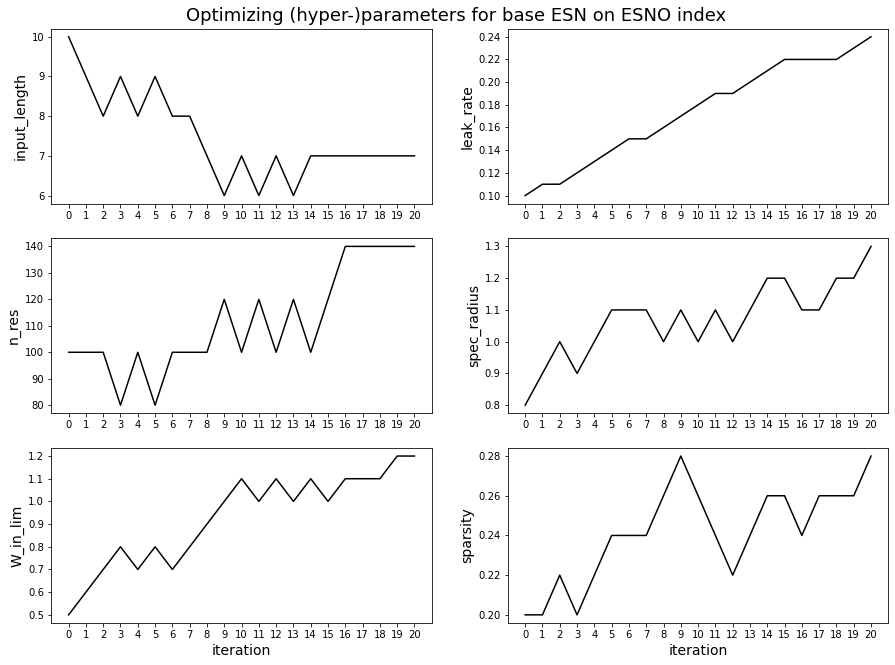

In [68]:
## Plot optimization of (hyper-)parameters over iterations.
## Store result from optimization with target_length=1
input_length_all = [10, 9, 8, 9, 8, 9, 8, 8, 7, 6, 7, 6, 7, 6, 7, 7, 7, 7, 7, 7, 7]
n_res_all = [100, 100, 100, 80, 100, 80, 100, 100, 100, 120, 100, 120, 100, 120, 100, 120, 140, 140, 140, 140, 140]
W_in_lim_all = [0.5, 0.6, 0.7, 0.8, 0.7, 0.8, 0.7, 0.8, 0.9,
                1.0, 1.1, 1.0, 1.1, 1.0, 1.1, 1.0, 1.1, 1.1, 1.1, 1.2, 1.2]
leak_rate_all = [0.1, 0.11, 0.11, 0.12, 0.13, 0.14, 0.15, 0.15, 0.16, 0.17, 0.18, 0.19, 0.19, 0.20, 0.21,
                 0.22, 0.22, 0.22, 0.22, 0.23, 0.24]
spec_radius_all = [0.8, 0.9, 1.0, 0.9, 1.0, 1.1, 1.1, 1.1, 1.0, 1.1, 1.0, 1.1, 1.0, 1.1, 1.2, 1.2,
                   1.1, 1.1, 1.2, 1.2, 1.3]
sparsity_all = [0.2, 0.2, 0.22, 0.2, 0.22, 0.24, 0.24, 0.24, 0.26, 0.28, 0.26, 0.24, 0.22,
                0.24, 0.26, 0.26, 0.24, 0.26, 0.26, 0.26, 0.28]



fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes[0,0].plot(range(n_iterations+1), input_length_all, color="k", label="input_length")  
axes[1,0].plot(range(n_iterations+1), n_res_all, color="k", label="original data")  
axes[2,0].plot(range(n_iterations+1), W_in_lim_all, color="k", label="original data")  
axes[0,1].plot(range(n_iterations+1), leak_rate_all, color="k", label="original data")  
axes[1,1].plot(range(n_iterations+1), spec_radius_all, color="k", label="original data")  
axes[2,1].plot(range(n_iterations+1), sparsity_all, color="k", label="original data")  

axes[0,0].set_xticks(ticks=range(n_iterations+1), labels=range(n_iterations+1))
axes[1,0].set_xticks(ticks=range(n_iterations+1), labels=range(n_iterations+1))
axes[2,0].set_xticks(ticks=range(n_iterations+1), labels=range(n_iterations+1))
axes[0,1].set_xticks(ticks=range(n_iterations+1), labels=range(n_iterations+1))
axes[1,1].set_xticks(ticks=range(n_iterations+1), labels=range(n_iterations+1))
axes[2,1].set_xticks(ticks=range(n_iterations+1), labels=range(n_iterations+1))

axes[2,0].set_xlabel("iteration", fontsize=14)
axes[2,1].set_xlabel("iteration", fontsize=14)

axes[0,0].set_ylabel("input_length", fontsize=14)
axes[1,0].set_ylabel("n_res", fontsize=14)
axes[2,0].set_ylabel("W_in_lim", fontsize=14)
axes[0,1].set_ylabel("leak_rate", fontsize=14)
axes[1,1].set_ylabel("spec_radius", fontsize=14)
axes[2,1].set_ylabel("sparsity", fontsize=14)

fig.suptitle('Optimizing (hyper-)parameters for base ESN on ESNO index', fontsize=18)
fig.subplots_adjust(top=0.95)
plt.show()

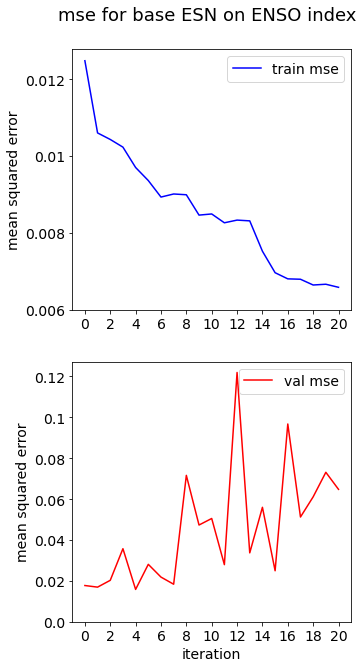

In [101]:
## Plot train and validation mse over iterations.
## Store result from optimization with target_length=1, 20 iterations with 10 runs each.
train_mse_all =[0.012480000000000002, 0.010600000000000002, 0.01043, 0.010230000000000001, 0.0097, 0.00936,
                0.00893, 0.009009999999999999, 0.008990000000000001, 0.008459999999999999, 0.008490000000000001,
                0.00826, 0.00833, 0.008310000000000001, 0.007519999999999999, 0.006959999999999999,
                0.006799999999999999, 0.00679, 0.00664, 0.006659999999999999, 0.00658]

val_mse_all =[0.017730000000000003, 0.01694, 0.02027, 0.035719999999999995, 0.01582, 0.02808, 0.02185, 0.018359999999999998,
              0.07156, 0.04728999999999999, 0.05048999999999999, 0.027919999999999993, 0.12183999999999999, 0.03369,
              0.05595, 0.02494, 0.09666000000000001, 0.0512, 0.06105999999999999, 0.07306, 0.06472]



fig, axes = plt.subplots(2, 1, figsize=(5,10))
axes[0].plot(range(n_iterations+1), train_mse_all, color="blue", label="train mse")  
axes[1].plot(range(n_iterations+1), val_mse_all, color="red", label="val mse")  
axes[0].set_xticks(ticks=np.arange(0, n_iterations+1, 2), labels=np.arange(0, n_iterations+1, 2), fontsize=14)
axes[1].set_xticks(ticks=np.arange(0, n_iterations+1, 2), labels=np.arange(0, n_iterations+1, 2), fontsize=14)
axes[0].set_yticks(ticks=np.arange(0.006,0.014,0.002), labels=np.arange(0.006,0.014,0.002), fontsize=14)
axes[1].set_yticks(ticks=np.arange(0,0.13,0.02), labels=np.arange(0,0.13,0.02), fontsize=14)
axes[1].set_xlabel("iteration", fontsize=14)
axes[0].set_ylabel("mean squared error", fontsize=14)
axes[1].set_ylabel("mean squared error", fontsize=14)
axes[0].legend(fontsize=14)
axes[1].legend(fontsize=14)

fig.suptitle('mse for base ESN on ENSO index', fontsize=18)
fig.subplots_adjust(top=0.92)
plt.show()

In [11]:
train_mse_all

[0.012480000000000002,
 0.010600000000000002,
 0.01043,
 0.010230000000000001,
 0.0097,
 0.00936,
 0.00893,
 0.009009999999999999,
 0.008990000000000001,
 0.008459999999999999,
 0.008490000000000001,
 0.00826,
 0.00833,
 0.008310000000000001,
 0.007519999999999999,
 0.006959999999999999,
 0.006799999999999999,
 0.00679,
 0.00664,
 0.006659999999999999,
 0.00658]

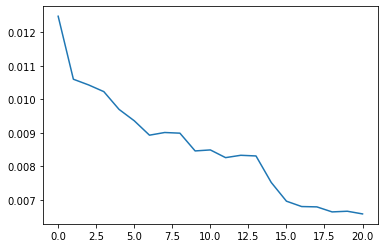

In [12]:
plt.plot(train_mse_all)

In [13]:
val_mse_all

[0.017730000000000003,
 0.01694,
 0.02027,
 0.035719999999999995,
 0.01582,
 0.02808,
 0.02185,
 0.018359999999999998,
 0.07156,
 0.04728999999999999,
 0.05048999999999999,
 0.027919999999999993,
 0.12183999999999999,
 0.03369,
 0.05595,
 0.02494,
 0.09666000000000001,
 0.0512,
 0.06105999999999999,
 0.07306,
 0.06472]

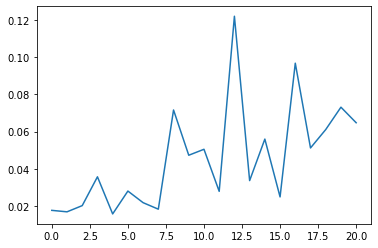

In [14]:
plt.plot(val_mse_all)

In [66]:
# Look at parameter evolution over iterations
input_length_all

[10, 9, 8, 9, 8, 9, 8, 8, 7, 6, 7, 6, 7, 6, 7, 7, 7, 7, 7, 7, 7]

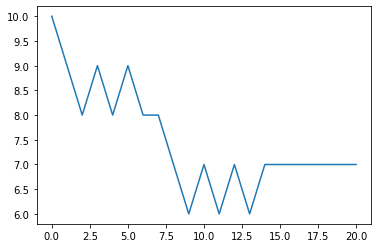

In [16]:
plt.plot(input_length_all)

In [17]:
n_res_all

[100,
 100,
 100,
 80,
 100,
 80,
 100,
 100,
 100,
 120,
 100,
 120,
 100,
 120,
 100,
 120,
 140,
 140,
 140,
 140,
 140]

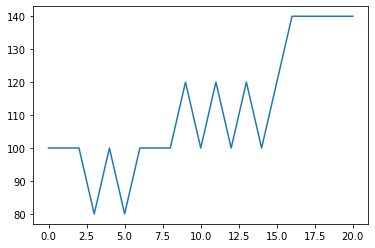

In [18]:
plt.plot(n_res_all)

In [19]:
W_in_lim_all

[0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.7,
 0.7999999999999999,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 1.0999999999999999,
 1.0999999999999999,
 1.2,
 1.2]

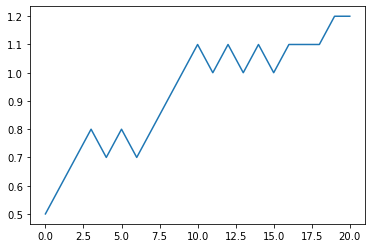

In [20]:
plt.plot(W_in_lim_all)

In [21]:
leak_rate_all

[0.1,
 0.11,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15000000000000002,
 0.15000000000000002,
 0.16000000000000003,
 0.17000000000000004,
 0.18000000000000005,
 0.19000000000000006,
 0.19000000000000006,
 0.20000000000000007,
 0.21000000000000008,
 0.22000000000000008,
 0.22000000000000008,
 0.22000000000000008,
 0.22000000000000008,
 0.2300000000000001,
 0.2400000000000001]

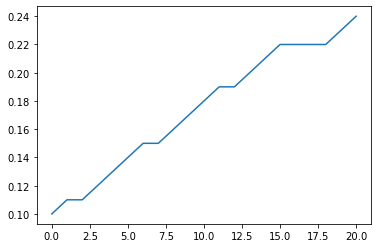

In [22]:
plt.plot(leak_rate_all)

In [23]:
spec_radius_all

[0.8,
 0.9,
 1.0,
 0.9,
 1.0,
 1.1,
 1.1,
 1.1,
 1.0,
 1.1,
 1.0,
 1.1,
 1.0,
 1.1,
 1.2000000000000002,
 1.2000000000000002,
 1.1,
 1.1,
 1.2000000000000002,
 1.2000000000000002,
 1.3000000000000003]

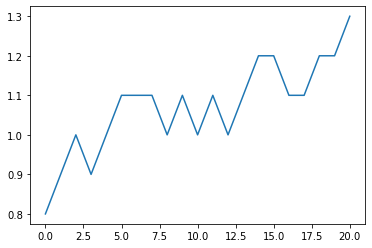

In [24]:
plt.plot(spec_radius_all)

In [25]:
sparsity_all

[0.2,
 0.2,
 0.22,
 0.2,
 0.22,
 0.24,
 0.24,
 0.24,
 0.26,
 0.28,
 0.26,
 0.24000000000000002,
 0.22000000000000003,
 0.24000000000000002,
 0.26,
 0.26,
 0.24000000000000002,
 0.26,
 0.26,
 0.26,
 0.28]

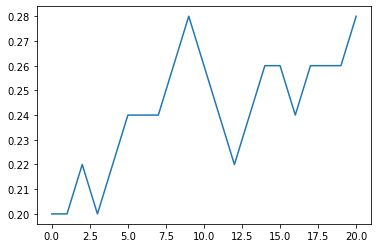

In [26]:
plt.plot(sparsity_all)

In [28]:
# Get optimal parameters on one sight:
i = 11

print("input_length: ", input_length_all[i])
print("n_res: ", n_res_all[i])
print("W_in_lim: ", np.round(W_in_lim_all[i], 2))
print("leak_rate: ", np.round(leak_rate_all[i], 2))
print("spec_radius: ", spec_radius_all[i])
print("sparsity: ", sparsity_all[i])

print("\ntrain_mse: ", np.round(train_mse_all[i], 4))
print("val_mse: ", np.round(val_mse_all[i], 4))


input_length:  6
n_res:  120
W_in_lim:  1.0
leak_rate:  0.19
spec_radius:  1.1
sparsity:  0.24000000000000002

train_mse:  0.0083
val_mse:  0.0279



shape of val input (samples, timesteps, features):  (339, 7, 1)
shape of train input (samples, timesteps, features):  (1353, 7, 1)

shape of model predictions on validation input (samples, 1):  (339, 1)
shape of val targets (samples, 1):  (339, 1)

train_mae:  0.0615
val_mae:  0.1185

train_mse:  0.0066
val_mse:  0.0829


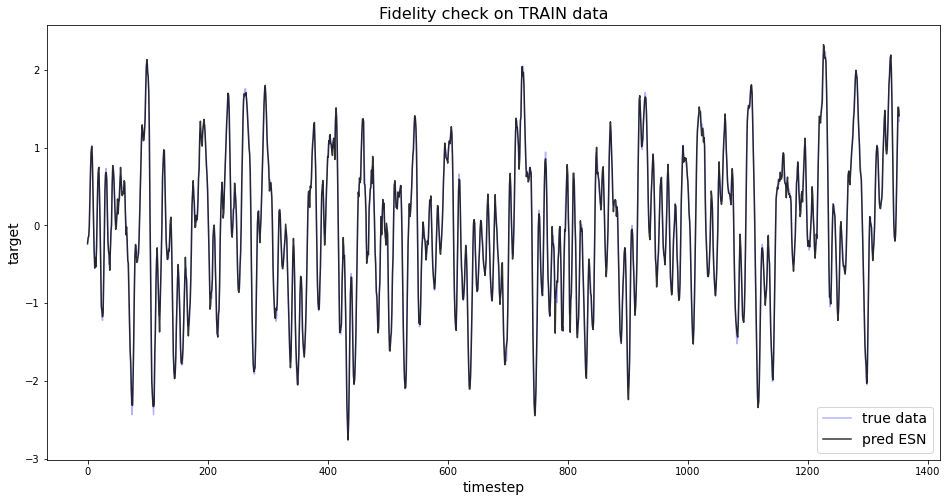

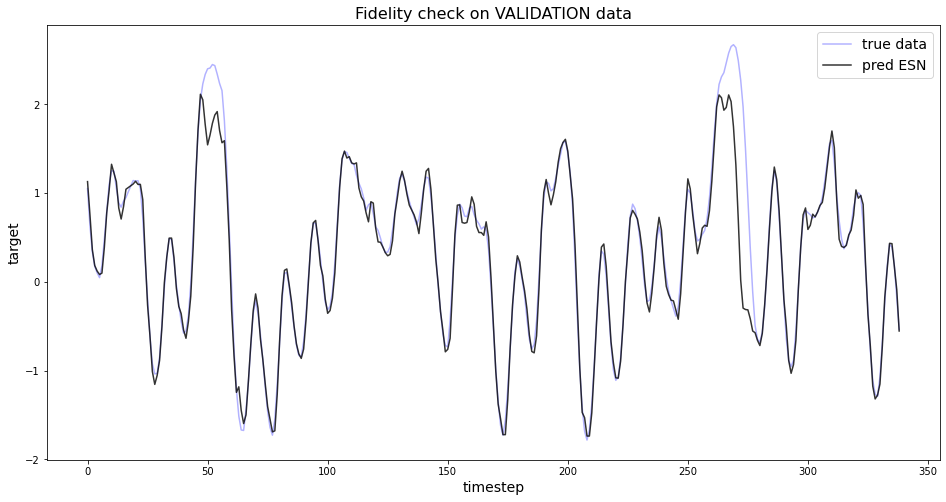

In [29]:
# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target, val_target,
                                                                       verbose=True)

In [30]:
# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
val_acc_neutral = sum((((val_pred>=-0.5) & (val_pred<=0.5)) == ((val_target>=-0.5) & (val_target<=0.5))) &
                       ((val_target>=-0.5) & (val_target<=0.5))) / sum(((val_target>=-0.5) & (val_target<=0.5)))

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))
train_acc_neutral = sum((((train_pred>=-0.5) & (train_pred<=0.5)) == ((train_target>=-0.5) & (train_target<=0.5))) &
                       ((train_target>=-0.5) & (train_target<=0.5))) / sum(((train_target>=-0.5) & (train_target<=0.5)))

In [31]:
# Get accuracy for target_length=1
# Note: Accurace prediction means having a certain event (e.g. El Nino) and correctly predicting 
#       to have that same event.
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.94
La Nina:  0.97
neutral:  0.91

Train accuracy:
El Nino:  0.97
La Nina:  0.97
neutral:  0.93


### Discussion on Optimizing (hyper-)parameters using Gradient Descent

Implementation appears a bit lengthy, could / should be functionalized. However, optimization with gradient descent seems to work quite fine!

Observe that we get back some problems from training ANNs, when we apply gradient descent optimization:

- overfitting: train_mse decreases while val_mse starts to rise or even explodes. Force early stopping!
- Can be stuck in local minimum of parameter space.

Some optional next steps to keep in mind:

- Check: Do multiple runs leed to at least comparable optimal parameters? (--> Reproducibility desired!)
- One could try to extend the optimization algorithm to DeepESN models: Further parameter n_layers.
- Could think of adding some form of *momentum*, like in ADAM optimizer.
- Could implement early-stopping, when all gradients are positiv and no lower mse can be achieved.

So far we have only optimized base ESN on normlized ENSO index with fixed:

- target_length = 1 
- activation = 'sigmoid'
- scaled_YN = False

If we find some high accuracy with this activation and scaling option, we should move on and optimize parameters for increasing target_length = 2, 3, 4, .., 12.

Could also try fine-tuning: Start with already optimized parameter setting and do another optimization run with smaller steps (= lower "learning rate").

#### Is that approach "new" or have others done the same?

First glance at Google revealed that there has been a lot of work on optimizing ESN (hyper-)parameters. Found e.g. [paper](https://arxiv.org/pdf/1903.05071.pdf) "Efficient Optimization of Echo State Networks for Time Series Datasets" using Bayesian optimization. Then found [paper](https://www.sciencedirect.com/science/article/abs/pii/S0925231220311425?via%3Dihub) on "Optimizing echo state network through a novel fisher maximization based stochastic gradient descent", at least the title suggests, there already has been a similar approach (Note: That paper is not freely available).

#### Switch to "stochastic" gradient descent

Instead of systematically turning input parameters up/down by single steps, one could randomly modify single (or multiple) parameters. Then calculate effect objective function (e.g. accuracy) and reject or accept modification. To avoid getting stuck in local minima to easily, need some "tunneling-rate": If modification leads to only slight decline in accuracy, still accept it as new setting.

Could also think about initializing base parameters randomly.

### Multi-runs for optimized (hyper-)parameters

Got optimized parameters from Gradient Descent optimization for base ESN on ENSO index for various target_lengths, worked with un-scaled ENSO index and 'sigmoid' activation.

Now do some 20 runs for each target_length with optimized parameters. Then plot train/validation mse and accuracy over target_length.

In [9]:
### Set parameters for optimization:

## Verbosity: Mute interim outputs from split_data, setESN, trainESN and predESN
verbose = False

## Parameters for splitting timeseries and setting up ESN model, that are kept UNCHANGED in optimization:
target_length_series = [1, 2, 3, 6, 12] # Define target lengths.
scaled_YN = False # If True: Scale input series with min/max scaling, where min/max are taken only from train data!
scale_to = 'zero_one' # If scaling is desired, choose interval to scale to: 'zero_one' --> [0,1] or 'one_one' --> [-1,1]
n_layers = 1 # Number of ESN layers in the model.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4
activation = 'sigmoid' # Desired activation function to be used in calculating reservoir state transition.

## Parameter settings for various target_lengths

# Split input series into samples of specified input length.
#input_length_series = [10, 11, 11, 21, 16] # series found in first optimization
input_length_series = [10, 11, 11, 15, 15] # manually adjusted

# Number of reservoir units.
#n_res_series = [100, 180, 160, 240, 160] # series found in first optimization
n_res_series = [100, 140, 160, 160, 160] # manually adjusted

# Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
#W_in_lim_series = [0.9, 1.1, 1.0, 1.2, 0.9] # series found in first optimization
W_in_lim_series = [0.9, 0.9, 0.9, 0.9, 0.9] # manually adjusted

# Leak rate used in transition function of reservoir states.
#leak_rate_series = [0.15, 0.16, 0.13, 0.14, 0.1] # series found in first optimization
leak_rate_series = [0.15, 0.15, 0.15, 0.15, 0.1] # manually adjusted

# Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
#spec_radius_series = [1.1, 1.6, 1.1, 1.3, 1.0] # series found in first optimization
spec_radius_series = [1.1, 1.1, 1.1, 1.1, 1.0] # manually adjusted

# Sparsity of reservoir weight matrix.
#sparsity_series = [0.2, 0.2, 0.2, 0.25, 0.15] # series found in first optimization
sparsity_series = [0.2, 0.2, 0.2, 0.20, 0.15] # manually adjusted

## Parameters for multi-run experiment:

# Number of runs we average over for each parameter setting (= each target_length) to
# achieve stable metrics and accuracy.
n_runs = 20

In [10]:
### Multi-run experiment for base ESN on ENSO index

## Initialize storage for mae, mse and acc for ALL parameter settings for ALL runs for train and validation data:
train_mae_all = np.zeros((len(target_length_series), n_runs))
train_mse_all = np.zeros((len(target_length_series), n_runs))
train_acc_ElNino_all = np.zeros((len(target_length_series), n_runs))
train_acc_LaNina_all = np.zeros((len(target_length_series), n_runs))
train_acc_neutral_all = np.zeros((len(target_length_series), n_runs))
val_mae_all = np.zeros((len(target_length_series), n_runs))
val_mse_all = np.zeros((len(target_length_series), n_runs))
val_acc_ElNino_all = np.zeros((len(target_length_series), n_runs))
val_acc_LaNina_all = np.zeros((len(target_length_series), n_runs))
val_acc_neutral_all = np.zeros((len(target_length_series), n_runs))


## Loop over distinct parameter settings (oriented on target_length_series):
for setting in range(len(target_length_series)):
    
    # Get current setting from series:
    target_length = target_length_series[setting]
    input_length = input_length_series[setting]
    n_res = n_res_series[setting]
    W_in_lim = W_in_lim_series[setting]
    leak_rate = leak_rate_series[setting]
    spec_radius = spec_radius_series[setting]
    sparsity = sparsity_series[setting]

    # Print status:
    print("\nsetting :", setting+1, "from ", len(target_length_series))
    
    ## Loop over desired number of runs per setting:  
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)

    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                    activation=activation, spec_radius=spec_radius, sparsity=sparsity,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Get validation accuracy: Rel. amount of correctly predicted events.
        val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
        val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
        val_acc_neutral = sum((((val_pred>=-0.5) & (val_pred<=0.5)) == ((val_target>=-0.5) & (val_target<=0.5))) &
                               ((val_target>=-0.5) & (val_target<=0.5))) / sum(((val_target>=-0.5) & (val_target<=0.5)))

        # Get train accuracy: Rel. amount of correctly predicted events.
        train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
        train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))
        train_acc_neutral = sum((((train_pred>=-0.5) & (train_pred<=0.5)) == ((train_target>=-0.5) & (train_target<=0.5))) &
                               ((train_target>=-0.5) & (train_target<=0.5))) / sum(((train_target>=-0.5) & (train_target<=0.5)))
        
        # Store current run's mae, mse and accuracy on train and validation data:
        train_mae_all[setting,run] = train_mae
        train_mse_all[setting,run] = train_mse
        train_acc_ElNino_all[setting,run] = train_acc_ElNino
        train_acc_LaNina_all[setting,run] = train_acc_LaNina
        train_acc_neutral_all[setting,run] = train_acc_neutral
        val_mae_all[setting,run] = val_mae
        val_mse_all[setting,run] = val_mse
        val_acc_ElNino_all[setting,run] = val_acc_ElNino
        val_acc_LaNina_all[setting,run] = val_acc_LaNina
        val_acc_neutral_all[setting,run] = val_acc_neutral
    


setting : 1 from  5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmppwwim4zy.py, line 20)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmppwwim4zy.py, line 20)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-09 10:12:26.393635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:693: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
2022-03-09 10:12:26.577126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:769: Visibl


setting : 2 from  5

setting : 3 from  5

setting : 4 from  5

setting : 5 from  5


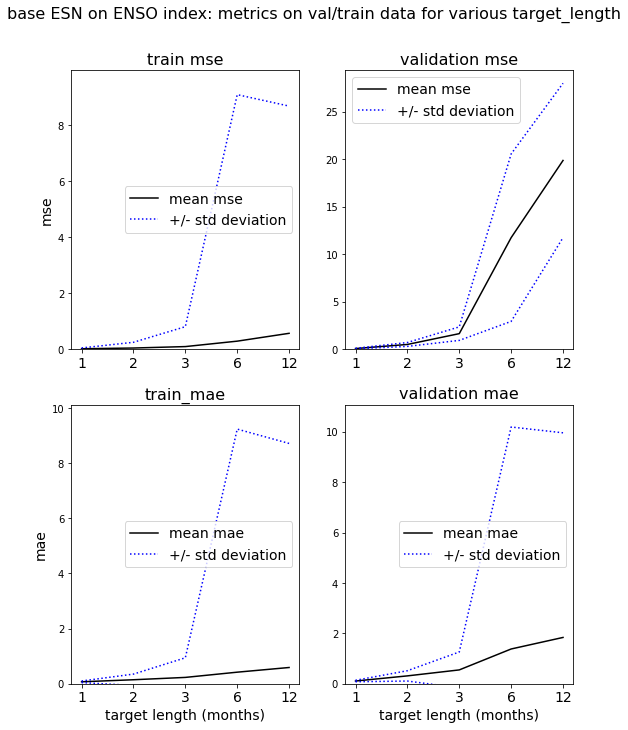

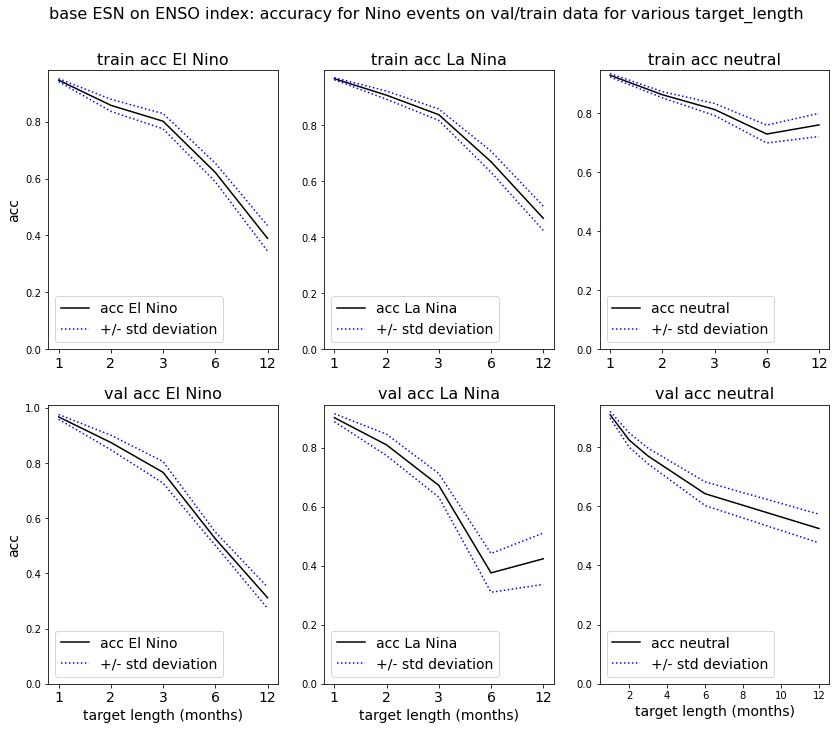

In [14]:
## Get mean and std for metrics and accuracy on train and validation data:
# NOTE: x-axis is compressed here! That might lead to wrong conclusions about trends!
# BETTER: Show x-axis in its natural spacing! 

# mean
train_mae_mean = np.mean(train_mae_all, axis=1)
train_mse_mean = np.mean(train_mse_all, axis=1)
train_acc_ElNino_mean = np.mean(train_acc_ElNino_all, axis=1)
train_acc_LaNina_mean = np.mean(train_acc_LaNina_all, axis=1)
train_acc_neutral_mean = np.mean(train_acc_neutral_all, axis=1)
val_mae_mean = np.mean(val_mae_all, axis=1)
val_mse_mean = np.mean(val_mse_all, axis=1)
val_acc_ElNino_mean = np.mean(val_acc_ElNino_all, axis=1)
val_acc_LaNina_mean = np.mean(val_acc_LaNina_all, axis=1)
val_acc_neutral_mean = np.mean(val_acc_neutral_all, axis=1)

# std deviation
train_mae_std = np.std(train_mae_all, axis=1)
train_mse_std = np.std(train_mse_all, axis=1)
train_acc_ElNino_std = np.std(train_acc_ElNino_all, axis=1)
train_acc_LaNina_std = np.std(train_acc_LaNina_all, axis=1)
train_acc_neutral_std = np.std(train_acc_neutral_all, axis=1)
val_mae_std = np.std(val_mae_all, axis=1)
val_mse_std = np.std(val_mse_all, axis=1)
val_acc_ElNino_std = np.std(val_acc_ElNino_all, axis=1)
val_acc_LaNina_std = np.std(val_acc_LaNina_all, axis=1)
val_acc_neutral_std = np.std(val_acc_neutral_all, axis=1)

## Plot mean (with +/- std) metrics on train and validation data:
fig, axes = plt.subplots(2, 2, figsize=(9,11))

axes[0,0].plot(range(len(target_length_series)), train_mse_mean, color="k", label="mean mse")
axes[0,0].plot(range(len(target_length_series)), train_mse_mean+val_mse_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[0,0].plot(range(len(target_length_series)), train_mse_mean-val_mse_std, color="b", linestyle="dotted")
axes[0,0].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[0,0].set_ylim(bottom=0)
axes[0,0].set_ylabel("mse", fontsize=14)
axes[0,0].set_title("train mse", fontsize=16)
axes[0,0].legend(fontsize=14)

axes[1,0].plot(range(len(target_length_series)), train_mae_mean, color="k", label="mean mae")
axes[1,0].plot(range(len(target_length_series)), train_mae_mean+val_mse_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[1,0].plot(range(len(target_length_series)), train_mae_mean-val_mse_std, color="b", linestyle="dotted")
axes[1,0].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[1,0].set_ylim(bottom=0)
axes[1,0].set_xlabel("target length (months)", fontsize=14)
axes[1,0].set_ylabel("mae", fontsize=14)
axes[1,0].set_title("train_mae", fontsize=16)
axes[1,0].legend(fontsize=14)

axes[0,1].plot(range(len(target_length_series)), val_mse_mean, color="k", label="mean mse")
axes[0,1].plot(range(len(target_length_series)), val_mse_mean+val_mse_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[0,1].plot(range(len(target_length_series)), val_mse_mean-val_mse_std, color="b", linestyle="dotted")
axes[0,1].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[0,1].set_ylim(bottom=0)
axes[0,1].set_title("validation mse", fontsize=16)
axes[0,1].legend(fontsize=14)

axes[1,1].plot(range(len(target_length_series)), val_mae_mean, color="k", label="mean mae")
axes[1,1].plot(range(len(target_length_series)), val_mae_mean+val_mse_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[1,1].plot(range(len(target_length_series)), val_mae_mean-val_mse_std, color="b", linestyle="dotted")
axes[1,1].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[1,1].set_ylim(bottom=0)
axes[1,1].set_xlabel("target length (months)", fontsize=14)
axes[1,1].set_title("validation mae", fontsize=16)
axes[1,1].legend(fontsize=14)

fig.suptitle('base ESN on ENSO index: metrics on val/train data for various target_length', fontsize=16)
fig.subplots_adjust(top=0.9)

plt.show()

## Plot mean (with +/- std) accuracy for distinct Nino events on train and validation data:
fig, axes = plt.subplots(2, 3, figsize=(14,11))

axes[0,0].plot(range(len(target_length_series)), train_acc_ElNino_mean, color="k", label="acc El Nino")
axes[0,0].plot(range(len(target_length_series)), train_acc_ElNino_mean+train_acc_ElNino_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[0,0].plot(range(len(target_length_series)), train_acc_ElNino_mean-train_acc_ElNino_std, color="b", linestyle="dotted")
axes[0,0].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[0,0].set_ylim(bottom=0)
axes[0,0].set_ylabel("acc", fontsize=14)
axes[0,0].set_title("train acc El Nino", fontsize=16)
axes[0,0].legend(fontsize=14)

axes[0,1].plot(range(len(target_length_series)), train_acc_LaNina_mean, color="k", label="acc La Nina")
axes[0,1].plot(range(len(target_length_series)), train_acc_LaNina_mean+train_acc_LaNina_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[0,1].plot(range(len(target_length_series)), train_acc_LaNina_mean-train_acc_LaNina_std, color="b", linestyle="dotted")
axes[0,1].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[0,1].set_ylim(bottom=0)
axes[0,1].set_title("train acc La Nina", fontsize=16)
axes[0,1].legend(fontsize=14)

axes[0,2].plot(range(len(target_length_series)), train_acc_neutral_mean, color="k", label="acc neutral")
axes[0,2].plot(range(len(target_length_series)), train_acc_neutral_mean+train_acc_neutral_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[0,2].plot(range(len(target_length_series)), train_acc_neutral_mean-train_acc_neutral_std, color="b", linestyle="dotted")
axes[0,2].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[0,2].set_ylim(bottom=0)
axes[0,2].set_title("train acc neutral", fontsize=16)
axes[0,2].legend(fontsize=14)

axes[1,0].plot(range(len(target_length_series)), val_acc_ElNino_mean, color="k", label="acc El Nino")
axes[1,0].plot(range(len(target_length_series)), val_acc_ElNino_mean+val_acc_ElNino_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[1,0].plot(range(len(target_length_series)), val_acc_ElNino_mean-val_acc_ElNino_std, color="b", linestyle="dotted")
axes[1,0].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[1,0].set_ylim(bottom=0)
axes[1,0].set_xlabel("target length (months)", fontsize=14)
axes[1,0].set_ylabel("acc", fontsize=14)
axes[1,0].set_title("val acc El Nino", fontsize=16)
axes[1,0].legend(fontsize=14)

axes[1,1].plot(range(len(target_length_series)), val_acc_LaNina_mean, color="k", label="acc La Nina")
axes[1,1].plot(range(len(target_length_series)), val_acc_LaNina_mean+val_acc_LaNina_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[1,1].plot(range(len(target_length_series)), val_acc_LaNina_mean-val_acc_LaNina_std, color="b", linestyle="dotted")
axes[1,1].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[1,1].set_ylim(bottom=0)
axes[1,1].set_xlabel("target length (months)", fontsize=14)
axes[1,1].set_title("val acc La Nina", fontsize=16)
axes[1,1].legend(fontsize=14)

#axes[1,2].plot(target_length_series, val_acc_neutral_mean, color="k", label="acc neutral")
#axes[1,2].plot(target_length_series, val_acc_neutral_mean+val_acc_neutral_std, color="b", linestyle="dotted", label="+/- std deviation")
#axes[1,2].plot(target_length_series, val_acc_neutral_mean-val_acc_neutral_std, color="b", linestyle="dotted")
#axes[1,2].set_ylim(bottom=0)
#axes[1,2].set_xlabel("target length (months)", fontsize=14)
#axes[1,2].set_title("val acc neutral", fontsize=16)
#axes[1,2].legend(fontsize=14)

axes[1,2].plot(range(len(target_length_series)), val_acc_neutral_mean, color="k", label="acc neutral")
axes[1,2].plot(range(len(target_length_series)), val_acc_neutral_mean+val_acc_neutral_std, color="b", linestyle="dotted", label="+/- std deviation")
axes[1,2].plot(range(len(target_length_series)), val_acc_neutral_mean-val_acc_neutral_std, color="b", linestyle="dotted")
axes[1,2].set_xticks(ticks=range(len(target_length_series)), labels=[1, 2, 3, 6, 12], fontsize=14)
axes[1,2].set_ylim(bottom=0)
axes[1,2].set_xlabel("target length (months)", fontsize=14)
axes[1,2].set_title("val acc neutral", fontsize=16)
axes[1,2].legend(fontsize=14)

fig.suptitle('base ESN on ENSO index: accuracy for Nino events on val/train data for various target_length', fontsize=16)
fig.subplots_adjust(top=0.9)

plt.show()



In [41]:
### Set parameters for fidelity check for specified target_length.

## Verbosity
verbose = False

## Parameters for splitting timeseries and setting up ESN model, that are kept UNCHANGED in optimization:
target_length = 6 # Define target length.
scaled_YN = True # If True: Scale input series with min/max scaling, where min/max are taken only from train data!
scale_to = 'zero_one' # If scaling is desired, choose interval to scale to: 'zero_one' --> [0,1] or 'one_one' --> [-1,1]
n_layers = 1 # Number of ESN layers in the model.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4
activation = 'sigmoid' # Desired activation function to be used in calculating reservoir state transition.

## Parameters for base ESN model

# Split input series into samples of specified input length.
input_length = 10

# Number of reservoir units.
n_res = 100

# Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
W_in_limi = 0.9

# Leak rate used in transition function of reservoir states.
leak_rate = 0.15

# Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
spec_radius = 1.1

# Sparsity of reservoir weight matrix.
sparsity = 0.2

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:693: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:769: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


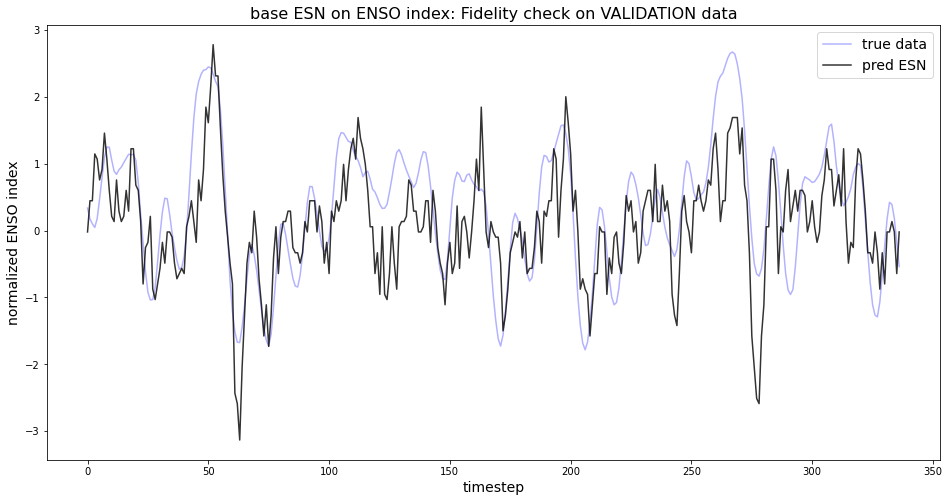


Validation accuracy:
El Nino:  0.47
La Nina:  0.5
neutral:  0.67

Train accuracy:
El Nino:  0.58
La Nina:  0.59
neutral:  0.69


In [42]:
## Model ENSO index with base ESN.  

# split_data according to chosen input_length to get train and validation inputs and targets.
train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                            input_length=input_length,
                                                                            target_length=target_length,
                                                                            time_lag=0, 
                                                                            train_val_split=0.8,
                                                                            val_samples_from='end',
                                                                            abs_to_rel_YN=False,
                                                                            binary_YN=False,
                                                                            scaled_YN=scaled_YN,
                                                                            scale_to=scale_to,
                                                                            verbose=verbose)

# setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers,
                            n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                            activation=activation, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

# trainESN to train output weights and bias.
model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


# predESN to get metrics [mae, mse] on train and validation data.
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target, val_target,
                                                                       verbose=verbose)

# Optionally re-scale predictions and targets, before getting accuracy:
if scaled_YN:
    train_pred = train_pred * (train_max - train_min) + train_min
    val_pred = val_pred * (train_max - train_min) + train_min
    train_target = train_target * (train_max - train_min) + train_min
    val_target = val_target * (train_max - train_min) + train_min

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
val_acc_neutral = sum((((val_pred>=-0.5) & (val_pred<=0.5)) == ((val_target>=-0.5) & (val_target<=0.5))) &
                       ((val_target>=-0.5) & (val_target<=0.5))) / sum(((val_target>=-0.5) & (val_target<=0.5)))

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))
train_acc_neutral = sum((((train_pred>=-0.5) & (train_pred<=0.5)) == ((train_target>=-0.5) & (train_target<=0.5))) &
                       ((train_target>=-0.5) & (train_target<=0.5))) / sum(((train_target>=-0.5) & (train_target<=0.5)))

# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('base ESN on ENSO index: Fidelity check on VALIDATION data', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('normalized ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()
        
        
# Get accuracy for target_length=1
# Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
#       to have that same event.
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))

### Baseline: Compare to linear Regression and CNN/LSTM hybrid ANN

To be able to estimate ESN model performance, we perform the same task with classical linear regression (and later with a hybrid CNN/LSTM network).

#### Linear Regression

Function *split_data* yields train and validation inputs and targets. Inputs have dimension (samples, timesteps), targets have timension (samples, 1). We are looking for weights $W$ with shape (timesteps, 1) and bias $b$ as single value.

The relation between train inputs $U$, weights, bias and train targets $Y$ reads:

$$U \cdot W + \overline{b} = Y$$

Note: Here $\overline{b}$ denotes a vector of shape (samples, 1), containing only the single output bias value $b$.

We switch to "augmented" notation and include ${b}$ as additional weight in $W$. This requires to add a column of *ones* as last column of $U$, for keeping dimensions right. This leads to:

$$U' \cdot W' = Y$$

where $U'$ and $W'$ denote train inputs and weights in augmented notation, respectively. 

Solving for $W'$ we need to invert $U'$, or get the pseudo-inverse $U'_{inv}$, since $U'$ is usually not a square matrix:

$$W' = U'_{inv} \cdot Y$$

Doing this, we obtain trained weights (including bias) and stick to augmented notation. To get predictions on validation inputs we also need to add a column of *ones* as last column to validation inputs.

In [62]:
## Set parameters and split data. Work with normalized ENSO index, for comparision:

input_length = 10
target_length = 6
scaled_YN = True
scale_to='zero_one'
verbose = True

# split_data according to chosen input_length to get train and validation inputs and targets.
train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)

raw data shape:  (1699,)
train_input shape:  (1347, 10, 1)
val_input shape:  (337, 10, 1)
train_target shape:  (1347, 1)
val_target shape:  (337, 1)
train_min:  -2.744474238122739
train_max:  2.2361730010575505


In [63]:
# Omit third dimension (= num features) for train and validation inputs:
train_input = train_input[:,:,0]
val_input = val_input[:,:,0]

print("train_input shape: (samples, timesteps)", train_input.shape)
print("val_input shape: (samples, timesteps)", val_input.shape)

train_input shape: (samples, timesteps) (1347, 10)
val_input shape: (samples, timesteps) (337, 10)


In [64]:
# Create vector of shape (samples, 1) containing ONEs to be added as additional column train and val inputs.
train_input_add = np.ones((train_input.shape[0], 1))
val_input_add = np.ones((val_input.shape[0], 1))
print("\ntrain_input_add shape: ",  train_input_add.shape)
print("val_input_add shape: ",  val_input_add.shape)

# Now add vector of ONEs as additional column to train and validation inputs
train_input_prime = np.concatenate((train_input, train_input_add), axis=-1)
val_input_prime = np.concatenate((val_input, val_input_add), axis=-1)
print("\ntrain inputs in augmented notation, shape: ", train_input_prime.shape)
print("val inputs in augmented notation, shape: ", val_input_prime.shape)


train_input_add shape:  (1347, 1)
val_input_add shape:  (337, 1)

train inputs in augmented notation, shape:  (1347, 11)
val inputs in augmented notation, shape:  (337, 11)


In [65]:
# Then need pseudo-inverse of train inputs in augmented notation
train_input_prime_inv = np.linalg.pinv(train_input_prime)

# Then get output weights, in augmented notation
W_prime = np.matmul(train_input_prime_inv, train_target)
       
print("W_prime shape: ", W_prime.shape)

W_prime shape:  (11, 1)



shape of model predictions on validation input (samples, 1):  (337, 1)
shape of val targets (samples, 1):  (337, 1)

Validation accuracy:
El Nino:  0.39
La Nina:  0.54
neutral:  0.71

Train accuracy:
El Nino:  0.47
La Nina:  0.51
neutral:  0.71

val_mae:  0.6363
train_mae:  0.5706


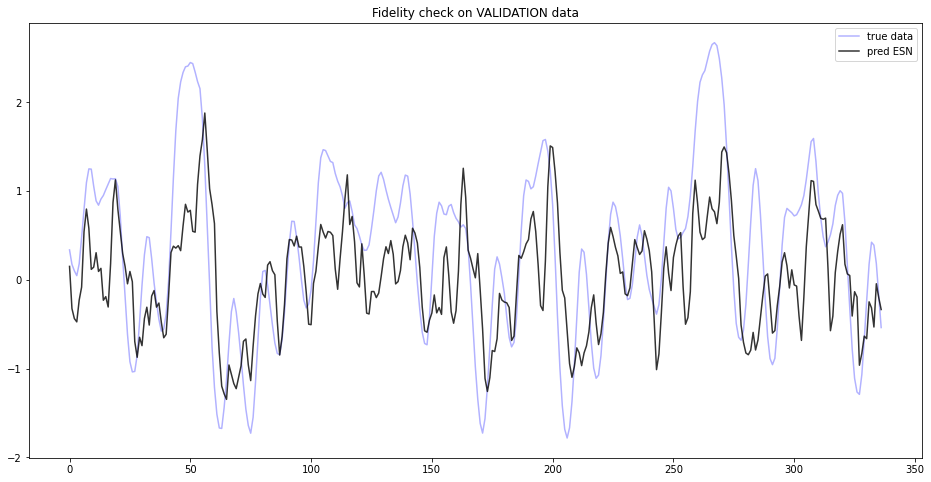

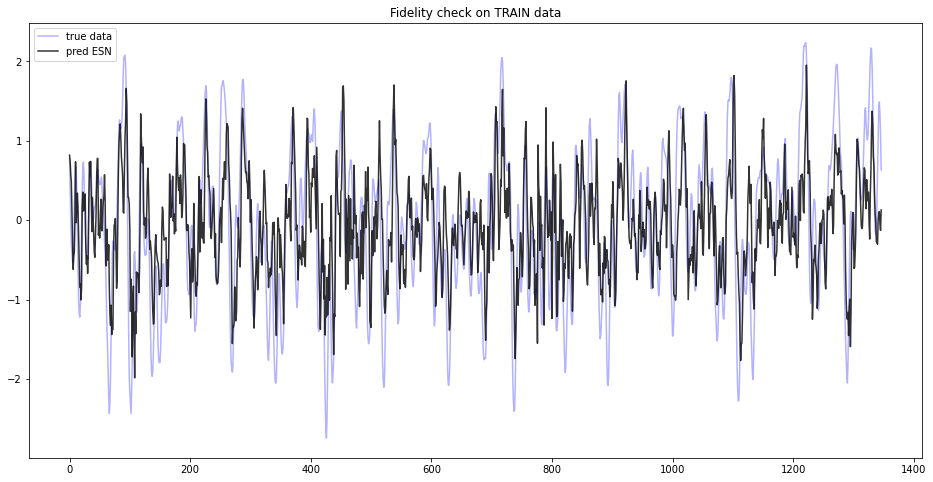

In [66]:
## Get predictions on val and train data with trained weights:
val_pred = np.matmul(val_input_prime, W_prime)
train_pred = np.matmul(train_input_prime, W_prime)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Rescale predictions and targets (sst anomalies):
train_target = train_target * (train_max - train_min) + train_min
train_pred = train_pred * (train_max - train_min) + train_min 
val_target = val_target * (train_max - train_min) + train_min
val_pred = val_pred * (train_max - train_min) + train_min 

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
val_acc_neutral = sum((((val_pred>=-0.5) & (val_pred<=0.5)) == ((val_target>=-0.5) & (val_target<=0.5))) &
                       ((val_target>=-0.5) & (val_target<=0.5))) / sum(((val_target>=-0.5) & (val_target<=0.5)))

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))
train_acc_neutral = sum((((train_pred>=-0.5) & (train_pred<=0.5)) == ((train_target>=-0.5) & (train_target<=0.5))) &
                       ((train_target>=-0.5) & (train_target<=0.5))) / sum(((train_target>=-0.5) & (train_target<=0.5)))


# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)

# Print metrics and accuracy.
# Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
#       to have that same event.
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))

print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data')
plt.legend()
plt.show()


# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target)),train_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred)),train_pred,'k',  alpha=0.8, label='pred ESN')
#plt.plot(range(len(train_pred)),(train_target[:,0]-b_out),'r',  alpha=0.8, label='pred ESN w/out b_out!!!')
plt.title('Fidelity check on TRAIN data')
plt.legend()
plt.show()